# <center>CS 7324 Lab 6
## <center>Francesco Trozzi (47779944) - George Sammit (04010135) - Megan Simons (46334773)

# Preparation

## Globals

In [269]:
# Ususally only expand the data once
RAW_DATA_EXPANSION = False
TRANSFER_EXPANSION = False
MLP_COMPARISON_EXPANSION = False

# Number of images/classification
MAX_IMAGES_PER_CLASSIFICATION = 10 # 2000

# Tweaks for testing
EPOCHS = 2 # 50 
DATA_SPLITS = 2 # 10
BATCH_SIZE = 32
PATIENCE = 10

# The classifications
CLASSIFICATIONS = { 'cheetah' : 0, 'jaguar' : 1, 'tiger' : 2, 'hyena' : 3}
NUM_CLASSES = 4

# For statistical comparison
ALPHA = 0.05

## Imports

In [270]:
import os
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from skimage import io
from skimage.io import imshow
from skimage.transform import resize
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.contingency_tables import mcnemar

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, Activation, Input, Dropout, Embedding, Flatten, Concatenate, Add, Conv2D, MaxPooling2D

## The Data
We are using the same dataset from Lab 2 which is https://www.kaggle.com/iluvchicken/cheetah-jaguar-and-tige.  It presents 4,000 400x400 color images of cheetahs, jaguars, tigers, and hyenas.  There are 1,000 images of each type of animals.  These images are taken in various settings, at different angles, with various profiles, and do not necessarily expose the entire animal.  They also include pups, males, and females.  These aspects may be seen in the following examples from the data set (two cells below)

### Data Augmentation
Used to take the raw images, and change them slightly (some minor rotations, etc.) to create new images.  We opt for pretty basic changes in the images.  Our images are of animals in the wild, so vertical flipping is likely to generate an unrealistic image.  We also don't want to rotate too much to preserve nature, e.g. trees don't normally grow at a 20-degree angle.  Finally, we want to ensure that we don't move the animal out of the image, e.g. cut off a head.

In [242]:
def change_feature():
    change = random.randint(0,2)
    if change > 0:
        return True
    return False    

In [243]:
def get_classifier(string_name):
    assert string_name in CLASSIFICATIONS.keys()
    return CLASSIFICATIONS[string_name]

def decode_classifier(classifier):
    for text in CLASSIFICATIONS.keys():
        if CLASSIFICATIONS[text] == classifier:
            return text

In [244]:
def augment_data(save_to_dir):

    base_dir = os.path.join('.', 'raw_images')
    image_files = os.listdir(base_dir)
    
    # There is a small chance that no changes will occur which we accept
    random = np.random.default_rng()

    print("Creating images in {}...".format(save_to_dir))
    loop_count = 0
    for image_file in image_files:
    
        if loop_count % 100 == 0:
            print("  {} images created".format(loop_count))
        loop_count += 1
    
        # Rotate up to 12 degrees
        rotation = np.random.randint(0,13) if change_feature() else 0
    
        # Shift in the range [0.05, 0.20)
        width_shift = np.random.uniform(0.05,0.2) if change_feature() else 0.0
        height_shift = np.random.uniform(0.05,0.2) if change_feature() else 0.0

        # Change in the range [0.05, 0.2)
        shear = np.random.uniform(0.05,0.2) if change_feature() else 0.0
        zoom = np.random.uniform(0.05,0.2) if change_feature() else 0.0

        # Don't rescale much
        rescale = 1./np.random.randint(240,260)if change_feature() else 0.0

        # Flip randomly
        flip = change_feature()
        
        image = io.imread(os.path.join(base_dir, image_file), as_gray=False)
        image = image.reshape((1,) + image.shape)
        classifier = image_file.split('_')[0] # 0 - animal, 1 = unimportant parts
        image_generator = ImageDataGenerator(rotation_range = rotation,
                                             horizontal_flip = flip,
                                             width_shift_range = width_shift,
                                             height_shift_range = height_shift,
                                             rescale = rescale,
                                             shear_range = shear,
                                             zoom_range = zoom,
                                             fill_mode = 'constant', # Nearest test to blur the animals
                                             cval=1)
        for _ in image_generator.flow(image,
                                      batch_size = 1, 
                                      save_to_dir = save_to_dir, 
                                      save_prefix = classifier, 
                                      save_format = 'jpeg'):
            # Only one augmentation per image
            break

    print("Done")
    print("{} images created".format(loop_count))

### Data Expansion
We have 1000 images of each type of 4 classifications.  Here, we double that.

We decided to do the expansion once prior to splitting the data, and do it manually rather than during the model fitting in real-time.

In [271]:
if RAW_DATA_EXPANSION:
    augment_data('expanded_images')

Creating images in expanded_images...
  0 images created
  100 images created
  200 images created
  300 images created
  400 images created
  500 images created
  600 images created
  700 images created
  800 images created
  900 images created
  1000 images created
  1100 images created
  1200 images created
  1300 images created
  1400 images created
  1500 images created
  1600 images created
  1700 images created
  1800 images created
  1900 images created
  2000 images created
  2100 images created
  2200 images created
  2300 images created
  2400 images created
  2500 images created
  2600 images created
  2700 images created
  2800 images created
  2900 images created
  3000 images created
  3100 images created
  3200 images created
  3300 images created
  3400 images created
  3500 images created
  3600 images created
  3700 images created
  3800 images created
  3900 images created
Done
4000 images created


### MLP Comparison Data
Create a set of data to use during the MLP comparison part.  We're using a shuffle split, so we're doing this to avoid testing on the same data that we trained on.

In [272]:
if MLP_COMPARISON_EXPANSION:
    augment_data('mlp_comp_images')

Creating images in mlp_comp_images...
  0 images created
  100 images created
  200 images created
  300 images created
  400 images created
  500 images created
  600 images created
  700 images created
  800 images created
  900 images created
  1000 images created
  1100 images created
  1200 images created
  1300 images created
  1400 images created
  1500 images created
  1600 images created
  1700 images created
  1800 images created
  1900 images created
  2000 images created
  2100 images created
  2200 images created
  2300 images created
  2400 images created
  2500 images created
  2600 images created
  2700 images created
  2800 images created
  2900 images created
  3000 images created
  3100 images created
  3200 images created
  3300 images created
  3400 images created
  3500 images created
  3600 images created
  3700 images created
  3800 images created
  3900 images created
Done
4000 images created


### Transfer Learning Data
Similar to above, we're creating a dataset that the model has not seen.

In [273]:
if TRANSFER_EXPANSION:
    augment_data('transfer_images')

Creating images in transfer_images...
  0 images created
  100 images created
  200 images created
  300 images created
  400 images created
  500 images created
  600 images created
  700 images created
  800 images created
  900 images created
  1000 images created
  1100 images created
  1200 images created
  1300 images created
  1400 images created
  1500 images created
  1600 images created
  1700 images created
  1800 images created
  1900 images created
  2000 images created
  2100 images created
  2200 images created
  2300 images created
  2400 images created
  2500 images created
  2600 images created
  2700 images created
  2800 images created
  2900 images created
  3000 images created
  3100 images created
  3200 images created
  3300 images created
  3400 images created
  3500 images created
  3600 images created
  3700 images created
  3800 images created
  3900 images created
Done
4000 images created


### Load the main image dataset

In [275]:
def load_images(directories):
    images = []
    classifications = []
    
    processed = {}
    for classifier in CLASSIFICATIONS.values():
        processed[classifier] = 0
    
    # Images are stored in the directory as follows:
    # ./raw_image
    #   -> <animal>_<image#>_<tag>.jpg  where the tag is resized (training) or val_resized (validtion).
    # We just lump them by animal and split into training/test ourselves.
    for directory in directories:
        
        base_dir = os.path.join('.', directory)
        image_files = os.listdir(base_dir)

        print("\nLoading images from {}...".format(directory))
        for image_file in image_files:
            if len(images) % 100 == 0:
                print("  {} images processed".format(len(images)))

            classifier = get_classifier(image_file.split('_')[0]) # 0 - animal, 1 = unimportant parts
            if processed[classifier] < MAX_IMAGES_PER_CLASSIFICATION:
                try:
                    images.append(io.imread(os.path.join(base_dir, image_file), as_gray=False))
                    classifications.append(classifier)
                    processed[classifier] += 1
                except Exception as ex:
                    print("Skipping " + file + " " + str(ex))

        num_images_processed = sum(processed.values())
        print("Done")
        print("{} images available".format(num_images_processed))
        
    return images, classifications

In [276]:
images, classifications = load_images(['raw_images', 'expanded_images'])


Loading images from raw_images...
  0 images processed
Done
40 images available

Loading images from expanded_images...
Done
40 images available


### Normalization

In [277]:
classifications = np.array(classifications , dtype=int)
print("Classifications array shape: {}".format(classifications.shape))

images = np.array(images, dtype=float)
max = images.max()
print("\nBefore normalization - Min: {} Max {}".format(images.min(), max))
images /= max
print("After normalization - Min: {} Max {}".format(images.min(), images.max()))
print("Images array shape: {}".format(images.shape))

Classifications array shape: (40,)

Before normalization - Min: 0.0 Max 255.0
After normalization - Min: 0.0 Max 1.0
Images array shape: (40, 400, 400, 3)


### OHE

In [278]:
classifications_ohe = to_categorical(classifications, NUM_CLASSES)

### Image Samples

In [279]:
def show_images(image_indexes, images, caption, label_image=False):
    """Show the images that correspond to the input indexes"""
    fig = plt.figure(figsize=(15, 4.6))
    fig.suptitle(caption)
    num_images_to_show = len(image_indexes)
    for plot_index in range(num_images_to_show):
        pic_index = image_indexes.pop()
        plt.subplot(1, num_images_to_show, plot_index + 1)
        plt.imshow(images[pic_index])
        if label_image:
            plt.title("Image " + str(plot_index))

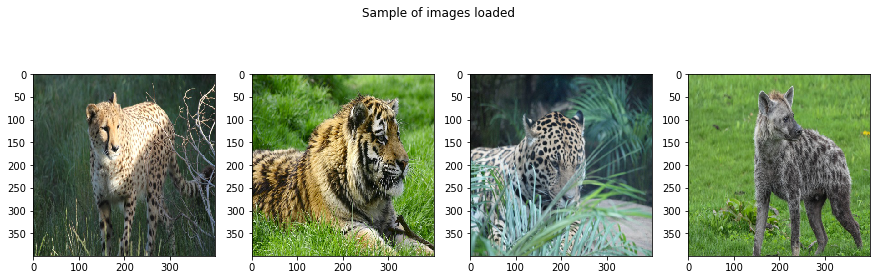

In [280]:
import random

def get_random_indexes(num_indexes, array):
    """Returns a set of 4 unique random indexes over the input array"""
    rands = set()
    while len(rands) < num_indexes:
        rands.add(random.randint(0, len(array)-1))
    return rands
        
def show_random_images(num_to_show, images, caption):
    """Displays four random images from the input list"""
    rands = get_random_indexes(num_to_show, images)
    show_images(rands, images, caption)
    
show_random_images(4, images, "Sample of images loaded")

Note that if you see black in the images above, it is likely a result of image augmentation.  We found that using "nearest" tended to blur the image, especially when it was part of the animal, so we chosed to just black-fill shifting/rotation.

## Metrics
As mentioned in a previous lab report the ability to classify animals in the wild has several potential applications. One such application could be facilitated by the use of outdoor cameras. For example so-called “urban” coyotes pose real threats to pets in Texas (https://texashillcountry.com/coyotes-texas-dangerous/). Strategically mounting cameras that have the ability to differentiate a coyote from a dog and alert appropriately could be valuable to local animal control agencies. In this application, misclassifications would pose a mere nuisances. We are going to build our model evaluation criteria based on this application. 

As mentioned as a misclassification would represent just a nuisances, while a correct classification of the animal in order to assess potential danger shall be a priority. For this reason recall represents a good metric. However, realistically if the camera is installed in the premises of a house it is going to see domestic animals way more frequently, if recall is used as a metric this might result in calling the local authorities multiple time a day, which will probably result in them to ignore your calls. We call potential pitfull as “The Boy Who Cried 'Wolf' scenario."  We then decide to sprinkle some precision into the evaluation metric, to make the model value more actual positives. We therefore use a custom F1 score, which represented a balance between the two metrics. The f1 score that we are going to implement is goint to still give more preference to recall while trying to minimize the false positives.

In [281]:
def custom_f1(y_true, y_pred): #taken from old keras source code
    epsilon = np.finfo(float).eps
    beta=2
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (possible_positives + epsilon)
    f1_val = (1+(beta**2))*(precision*recall)/(((beta**2)*precision)+recall+epsilon)
    return f1_val

The when the beta is higher then 1, the custom f1 value recall more then precision. The formula for the custom f1 was taken from: https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226

#### Utility for comparing models

In [282]:
def compare_comps(comps):
    for i in range(len(comps)):
        for j in range(i+1, len(comps)):
            table = table_compiler(comps[i], comps[j])
            result = mcnemar(table, exact=False)
            print(models_titles[i]+' vs '+ models_titles[j])
            print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
            if result.pvalue > alpha:
                print('No meaningful difference in performance (fail to reject H0)')
                print('-----------------------------------------------------------')
                print()
            else:
                print('Meaningful difference in performance (reject H0)')
                print('------------------------------------------------')
                print()

## Train/Test Split
When normal training/test split is done, the split is done randomly and places the first X% of data in training and places the remaining X% of data in testing. Since we cannot fully ensure our training/test split is done randomly, there might end up being some bias. If one class ended up fully in training or testing, this would lead to our model not being able to learn and classify each animal properly. Therefore, to ensure total randomization between the 4 equal classifications, we will use shuffle splits. This way, we can decrease the likelihood of bias occurring in the split by decreasing the likelihood that the classes will not be split well. Since the number of images is equal among classes, once the shuffling has occurred we can do the usual 0.8/0.2 train/test split.

In [283]:
rs = ShuffleSplit(n_splits=DATA_SPLITS, test_size=.2, random_state=0)
rs.get_n_splits(images)
iteration = 0
for train_index, test_index in rs.split(images):
    print("Split #{}: Training samples = {} Testing samples = {}" .format(iteration, 
                                                                          len(train_index), 
                                                                          len(test_index)))
    iteration += 1

Split #0: Training samples = 32 Testing samples = 8
Split #1: Training samples = 32 Testing samples = 8


# Modeling

### Utilities

In [284]:
def plot_history(histories, to_plot):
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,6))
    for history in histories:
        axs[0].plot(history.history[to_plot])
        axs[1].plot(history.history['val_'+to_plot])

    axs[0].set_title('Training ')
    axs[1].set_title('Validation')
    for ax in axs.flat:
        ax.set(xlabel='Epochs')
    
    plt.suptitle('Model ' + to_plot.capitalize())
    plt.tight_layout()
    plt.show()
    
def plot_loss(histories):
    plot_history(histories, 'loss')
    
def plot_custom_f1(histories):
    plot_history(histories, 'custom_f1')

### MLP

In [137]:
histories_mlp = []
flattened_image_size = images.shape[1] * images.shape[2] * images.shape[3]

mlp = Sequential()
mlp.add( Flatten())
mlp.add( Dense(input_dim=flattened_image_size, units=500, activation='relu') )
mlp.add( Dense(units=250, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])
for train, test in rs.split(images):
    history = mlp.fit(x=images[train], 
                      y=classifications_ohe[train],
                      validation_data = (images[test], classifications_ohe[test]),
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS, 
                      shuffle=True,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_mlp.append(history)    
mlp.summary()

Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 22s 339ms/sample - loss: 207.0048 - custom_f1: 0.1094 - val_loss: 1778.3904 - val_custom_f1: 0.2500
Epoch 2/2
64/64 [==============================] - 8s 119ms/sample - loss: 1222.5015 - custom_f1: 0.3281 - val_loss: 181.8643 - val_custom_f1: 0.2500
Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 11s 165ms/sample - loss: 273.5909 - custom_f1: 0.2188 - val_loss: 458.6704 - val_custom_f1: 0.2500
Epoch 2/2
64/64 [==============================] - 8s 127ms/sample - loss: 343.6491 - custom_f1: 0.2656 - val_loss: 265.6915 - val_custom_f1: 0.3750
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________
dense_15 (Dense)          

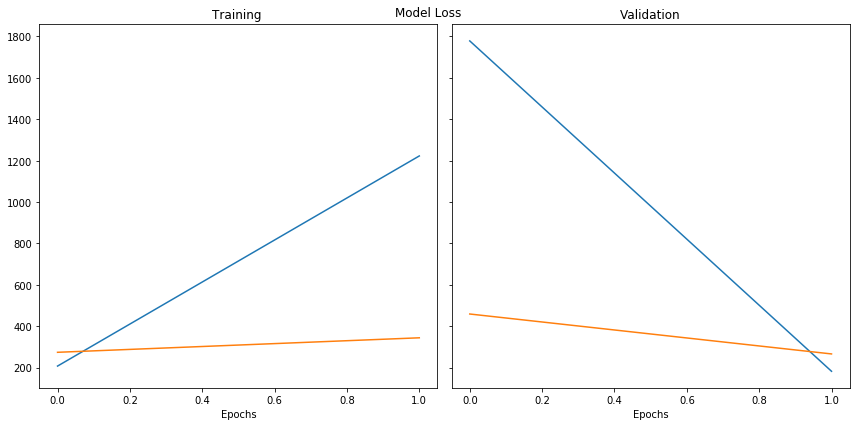

In [139]:
plot_loss(histories_mlp)

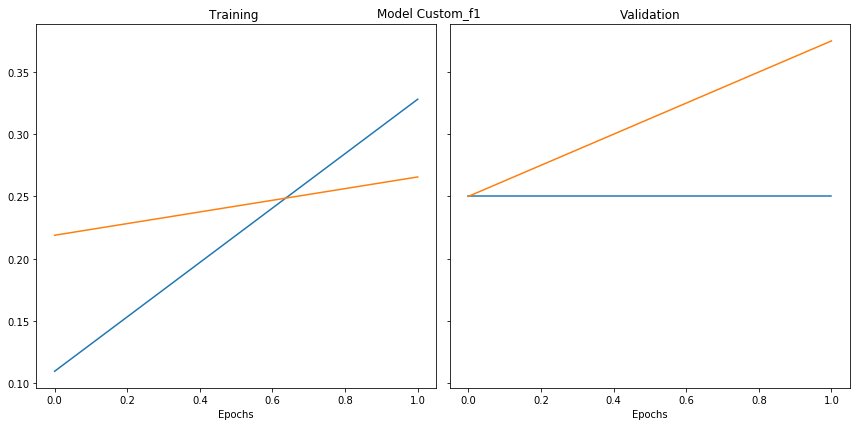

In [140]:
plot_custom_f1(histories_mlp)

### CNN1

In [141]:
histories_cnn1 = []

cnn1 = Sequential()
cnn1.add( Conv2D(filters=16, kernel_size= (4, 4), padding='valid', 
                 input_shape=(images.shape[1], images.shape[2], images.shape[3]),
                 data_format="channels_last") )
cnn1.add( MaxPooling2D(pool_size=(4, 4), data_format="channels_last") )
cnn1.add( Activation('relu') )
cnn1.add( Flatten() )
cnn1.add( Dense(NUM_CLASSES) )
cnn1.add( Activation('softmax') )

cnn1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])

for train, test in rs.split(images):
    history = cnn1.fit(x=images[train], 
                       y=classifications_ohe[train],
                       validation_data = (images[test], classifications_ohe[test]),
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       shuffle=True, 
                       callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_cnn1.append(history)

cnn1.summary()

Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 7s 116ms/sample - loss: 34.9387 - custom_f1: 0.1250 - val_loss: 98.2756 - val_custom_f1: 0.1250
Epoch 2/2
64/64 [==============================] - 4s 60ms/sample - loss: 52.9505 - custom_f1: 0.2812 - val_loss: 28.3861 - val_custom_f1: 0.1250
Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 4s 61ms/sample - loss: 29.1704 - custom_f1: 0.1562 - val_loss: 2.7578 - val_custom_f1: 0.5000
Epoch 2/2
64/64 [==============================] - 5s 78ms/sample - loss: 2.2149 - custom_f1: 0.4856 - val_loss: 8.9177 - val_custom_f1: 0.1250
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 397, 397, 16)      784       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 99, 99, 

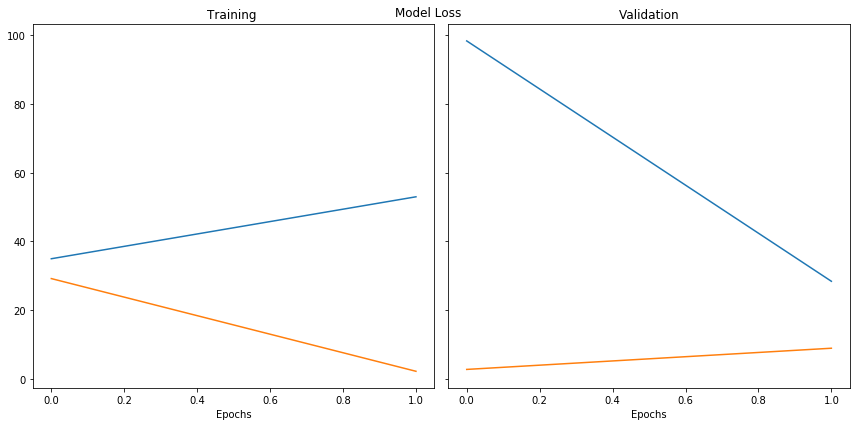

In [142]:
plot_loss(histories_cnn1)

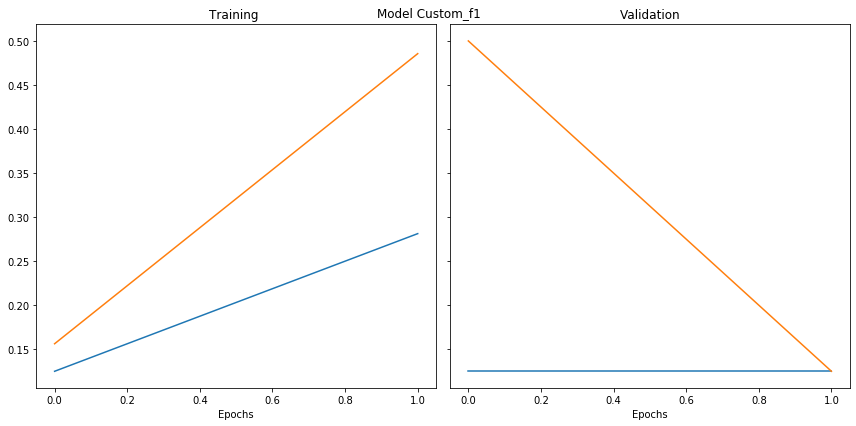

In [143]:
plot_custom_f1(histories_cnn1)

## Changing the Architecture

### CNN #2
This model is based on Alexnet.

In [144]:
histories_cnn2 = []

cnn2 = Sequential()    
cnn2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(images.shape[1], images.shape[2], images.shape[3]), kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last" ))
cnn2.add(Conv2D(filters=64, kernel_size= (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last" ))
cnn2.add(Conv2D(filters=96, kernel_size= (2, 2), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2.add(Dropout(0.25))
cnn2.add(Conv2D(filters=96, kernel_size= (2, 2), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01))) 
cnn2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last") )
cnn2.add(Activation('relu') )
cnn2.add(Flatten() )
cnn2.add(Dense(4096, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(4096, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
cnn2.add(Dropout(0.5)) 
cnn2.add(Dense(NUM_CLASSES, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.01), activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])

for train, test in rs.split(images):

    history2 = cnn2.fit(x=images[train], 
                       y=classifications_ohe[train],
                       validation_data = (images[test], classifications_ohe[test]),
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       shuffle=True, 
                       callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_cnn2.append(history2)
    
cnn2.summary()

Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 21s 327ms/sample - loss: 440.5935 - custom_f1: 0.2216 - val_loss: 146.8272 - val_custom_f1: 0.3125
Epoch 2/2
64/64 [==============================] - 13s 209ms/sample - loss: 152.7809 - custom_f1: 0.3136 - val_loss: 122.7659 - val_custom_f1: 0.0769
Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 16s 252ms/sample - loss: 120.2615 - custom_f1: 0.1406 - val_loss: 110.1909 - val_custom_f1: 0.0000e+00
Epoch 2/2
64/64 [==============================] - 14s 223ms/sample - loss: 107.5718 - custom_f1: 0.0000e+00 - val_loss: 100.2659 - val_custom_f1: 0.0000e+00
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 400, 400, 32)      896       
_________________________________________________________________
max_pooling2d_

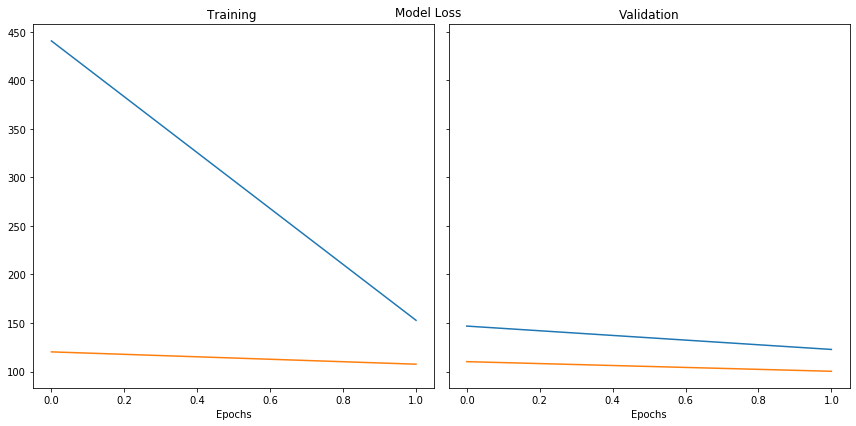

In [146]:
plot_loss(histories_cnn2)

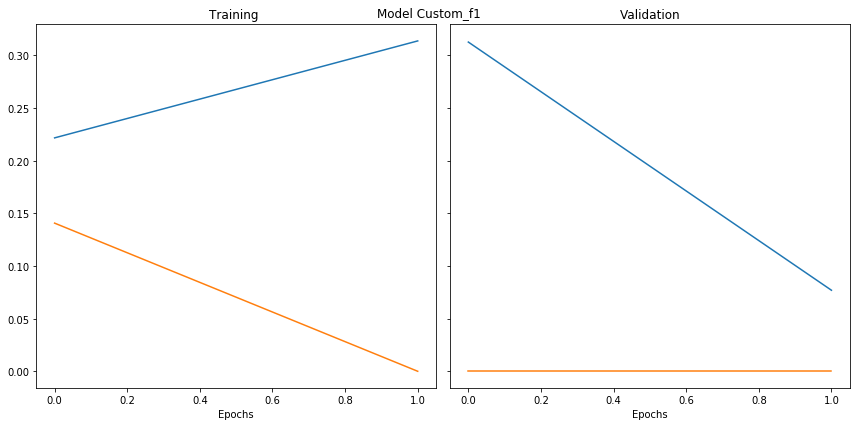

In [147]:
plot_custom_f1(histories_cnn2)

### CNN #3
This is a convolutional network with residual layer shamlessly taken from notebook 12

In [148]:
l2_lambda =0.01
histories_cnn3 = []

input_holder = Input(shape=(images.shape[1], images.shape[2], images.shape[3]))

x = Conv2D(filters=32,
               input_shape = (images.shape[1], images.shape[2], images.shape[3]),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(4)(x)
x = Activation('softmax')(x)

cnn3 = Model(inputs=input_holder, outputs=x)
cnn3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])

for train, test in rs.split(images):

    history3 = cnn3.fit(x=images[train], 
                       y=classifications_ohe[train],
                       validation_data = (images[test], classifications_ohe[test]),
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       shuffle=True, 
                       callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_cnn3.append(history3)
    
cnn3.summary()

Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 15s 233ms/sample - loss: 69.2790 - custom_f1: 0.2106 - val_loss: 104.0625 - val_custom_f1: 0.1250
Epoch 2/2
64/64 [==============================] - 15s 232ms/sample - loss: 53.5662 - custom_f1: 0.2500 - val_loss: 9.0104 - val_custom_f1: 0.2500
Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 16s 249ms/sample - loss: 7.8827 - custom_f1: 0.3508 - val_loss: 5.5488 - val_custom_f1: 0.4054
Epoch 2/2
64/64 [==============================] - 16s 255ms/sample - loss: 6.2382 - custom_f1: 0.4294 - val_loss: 6.3775 - val_custom_f1: 0.3125
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 400, 400, 3) 0                                            
__________

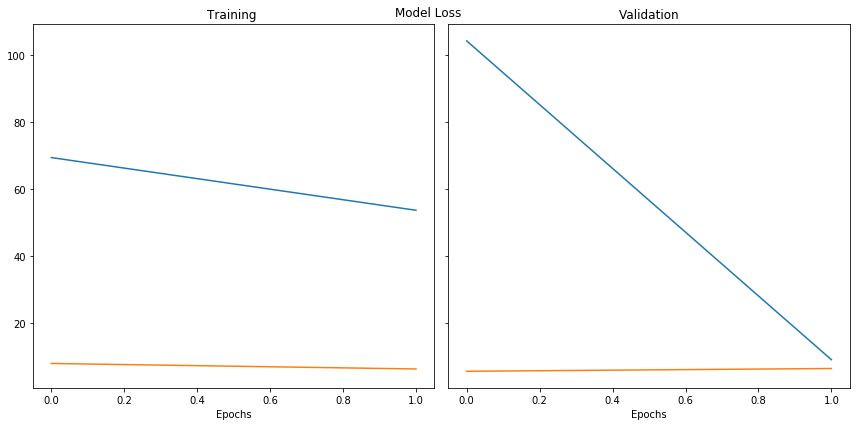

In [149]:
plot_loss(histories_cnn3)

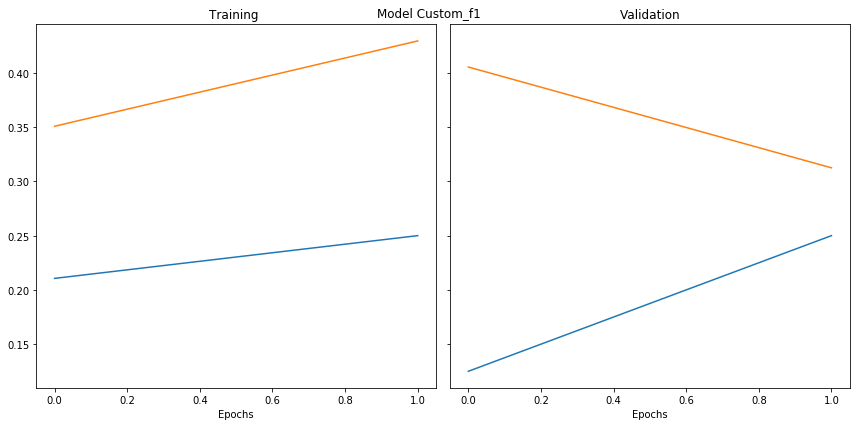

In [150]:
plot_custom_f1(histories_cnn3)

# Variations
## CNN2 V.2

In [151]:
histories_cnn2_2 = []

cnn2_2 = Sequential()    
cnn2_2.add(Conv2D(filters=32, kernel_size=(11, 11), padding='same', input_shape=(images.shape[1], images.shape[2], images.shape[3]), kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2_2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last" ))
cnn2_2.add(Conv2D(filters=64, kernel_size= (5, 5), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2_2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last" ))
cnn2_2.add(Conv2D(filters=96, kernel_size= (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2_2.add(Dropout(0.25))
cnn2_2.add(Conv2D(filters=96, kernel_size= (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01)))
cnn2_2.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', data_format="channels_last", kernel_regularizer=l2(0.01))) 
cnn2_2.add(MaxPooling2D(pool_size=(3, 3), data_format="channels_last") )
cnn2_2.add(Activation('relu') )
cnn2_2.add(Flatten() )
cnn2_2.add(Dense(4096, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
cnn2_2.add(Dropout(0.5))
cnn2_2.add(Dense(4096, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
cnn2_2.add(Dropout(0.5)) 
cnn2_2.add(Dense(NUM_CLASSES, kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.01), activation='softmax'))

cnn2_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])

for train, test in rs.split(images):

    history2_2 = cnn2_2.fit(x=images[train], 
                       y=classifications_ohe[train],
                       validation_data = (images[test], classifications_ohe[test]),
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       shuffle=True, 
                       callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_cnn2_2.append(history2_2)
    
cnn2_2.summary()

Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 46s 712ms/sample - loss: 466.6947 - custom_f1: 0.1891 - val_loss: 177.3682 - val_custom_f1: 0.1250
Epoch 2/2
64/64 [==============================] - 42s 663ms/sample - loss: 175.4522 - custom_f1: 0.1875 - val_loss: 127.7907 - val_custom_f1: 0.2174
Train on 64 samples, validate on 16 samples
Epoch 1/2
64/64 [==============================] - 47s 730ms/sample - loss: 125.0105 - custom_f1: 0.1159 - val_loss: 116.4561 - val_custom_f1: 0.0000e+00
Epoch 2/2
64/64 [==============================] - 51s 791ms/sample - loss: 114.0573 - custom_f1: 0.0000e+00 - val_loss: 107.3511 - val_custom_f1: 0.0000e+00
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 400, 400, 32)      11648     
_________________________________________________________________
max_pooling2d_

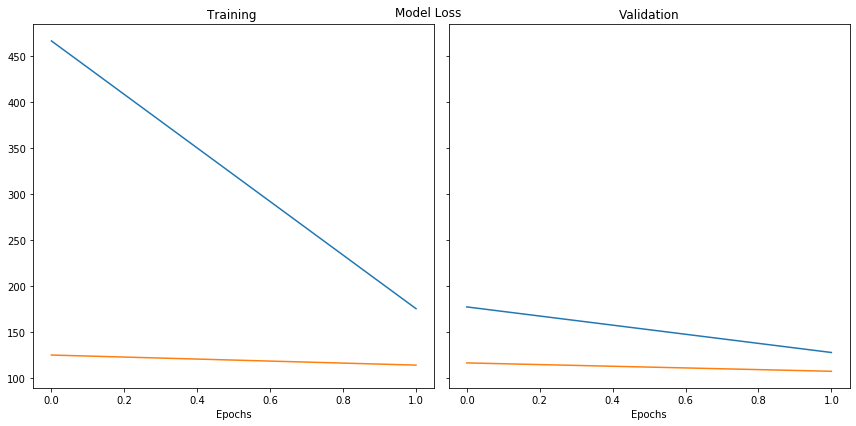

In [152]:
plot_loss(histories_cnn2_2)

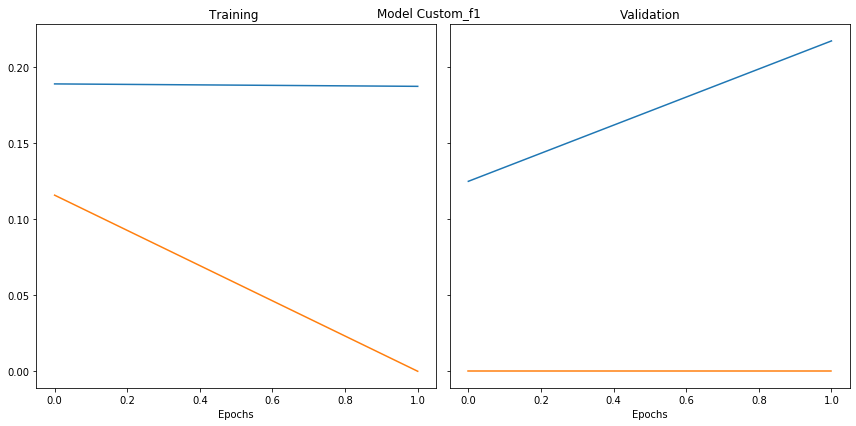

In [153]:
plot_custom_f1(histories_cnn2_2)

## CNN3 V.2

In [285]:
classifications_ohe = to_categorical(classifications, NUM_CLASSES)

l2_lambda =0.01
hclassifications_ohe = to_categorical(classifications, NUM_CLASSES)

histories_cnn3_2 = []

input_holder = Input(shape=(images.shape[1], images.shape[2], images.shape[3]))

x = Conv2D(filters=64,
               input_shape = (images.shape[1], images.shape[2], images.shape[3]),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=256,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=128,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(4)(x)
x = Activation('softmax')(x)

cnn3_2 = Model(inputs=input_holder, outputs=x)
cnn3_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])

for train, test in rs.split(images):

    history3_2 = cnn3_2.fit(x=images[train], 
                       y=classifications_ohe[train],
                       validation_data = (images[test], classifications_ohe[test]),
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       shuffle=True, 
                       callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE)])
    histories_cnn3_2.append(history3_2)
    
    
cnn3_2.summary()

Train on 32 samples, validate on 8 samples
Epoch 1/2
32/32 [==============================] - 80s 3s/sample - loss: 16.7368 - custom_f1: 0.1290 - val_loss: 2595.5715 - val_custom_f1: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 37s 1s/sample - loss: 1619.3502 - custom_f1: 0.3438 - val_loss: 327.6520 - val_custom_f1: 0.1250
Train on 32 samples, validate on 8 samples
Epoch 1/2
32/32 [==============================] - 42s 1s/sample - loss: 684.3609 - custom_f1: 0.2812 - val_loss: 158.7434 - val_custom_f1: 0.3750
Epoch 2/2
32/32 [==============================] - 37s 1s/sample - loss: 274.9545 - custom_f1: 0.2188 - val_loss: 87.6601 - val_custom_f1: 0.3750
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 400, 400, 3) 0                                            
_______

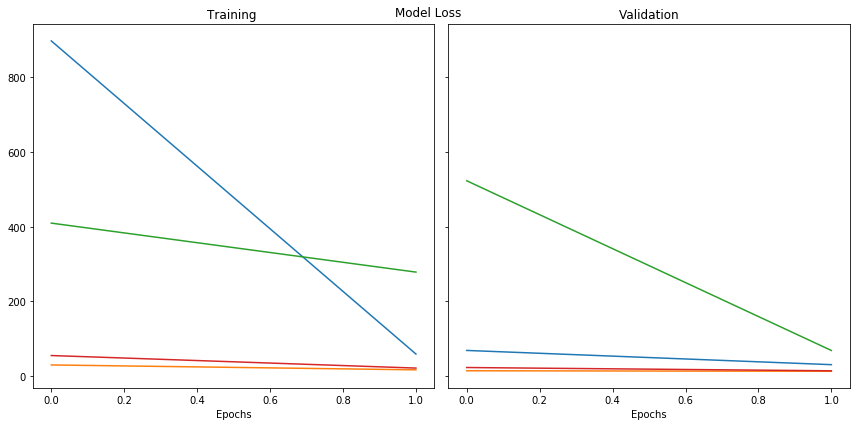

In [156]:
plot_loss(histories_cnn3_2)

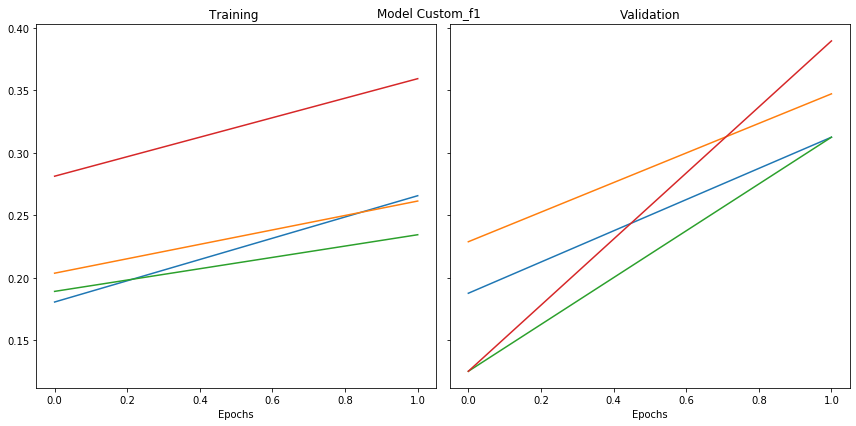

In [157]:
plot_custom_f1(histories_cnn3_2)

## Visualization/Interpretation

In [158]:
def table_compiler(model1, model2):

    len1, len2 = len(model1), len(model2)
    if len1 != len2:
        print('Error: models hould have same lenght as they should be from same testing set')

    # Initialize table
    table = np.zeros((2,2))
    
    #fill the table
    for i in range(len1):
        if model1[i] == True and model2[i] == True:
            table[0][0] += 1
        elif model1[i] == True and model2[i] == False:
            table[0][1] += 1
        elif model1[i] == False and model2[i] == True:
            table[1][0] += 1
        elif model1[i] == False and model2[i] == False:
            table[1][1] += 1
            
    return table

In [159]:
models = [mlp, cnn1, cnn2, cnn2_2, cnn3, cnn3_2]
models_titles = ['mlp', 'cnn1', 'cnn2', 'cnn2_2', 'cnn3', 'cnn3_2']
true_counts = []
comps = []
for model in models:
    yhat = np.argmax(model.predict(images[test]), axis=1)
    comp = np.equal(yhat, classifications[test])
    comps.append(comp)
    true_counts.append(sum(comp))

### Prediction accuracy of different models 

[6, 2, 3, 3, 5, 6]
16


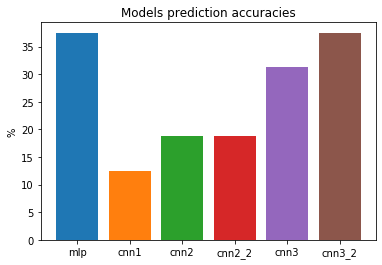

In [160]:
print(true_counts)
print(len(comps[0]))
plt.figure()
for i in range(len(true_counts)):
    plt.bar(x=i, height=(true_counts[i]/len(comps[i])*100))

plt.title('Models prediction accuracies')
plt.ylabel('%')
plt.xticks(np.arange(6), models_titles)
plt.show()

### Statistical comparison of different models

The McNemar was used to evaluate if the difference amongts the different models are statistically significant.
As it can be seen below our models perform similarly with no meanigful difference between them.

In [162]:
compare_comps(comps)

mlp vs cnn1
statistic=1.125, p-value=0.289
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

mlp vs cnn2
statistic=0.444, p-value=0.505
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

mlp vs cnn2_2
statistic=0.444, p-value=0.505
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

mlp vs cnn3
statistic=0.000, p-value=1.000
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

mlp vs cnn3_2
statistic=0.125, p-value=0.724
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

cnn1 vs cnn2
statistic=0.000, p-value=1.000
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------

cnn1 vs cnn

### Visual Unboxing of our models

In [163]:
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

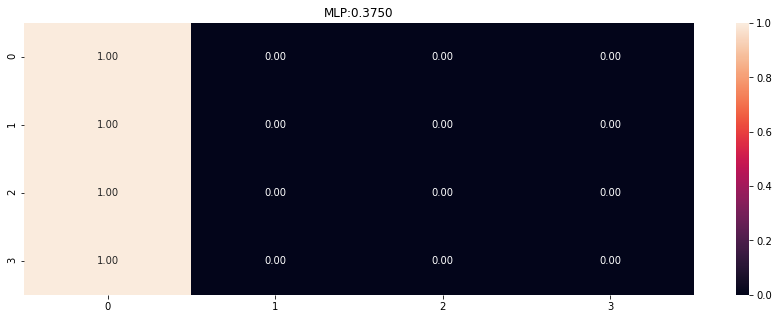

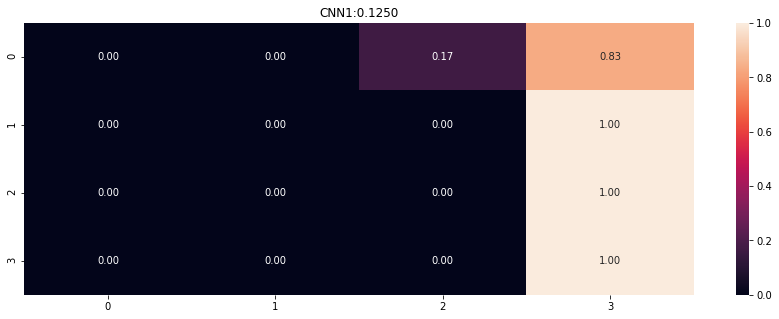

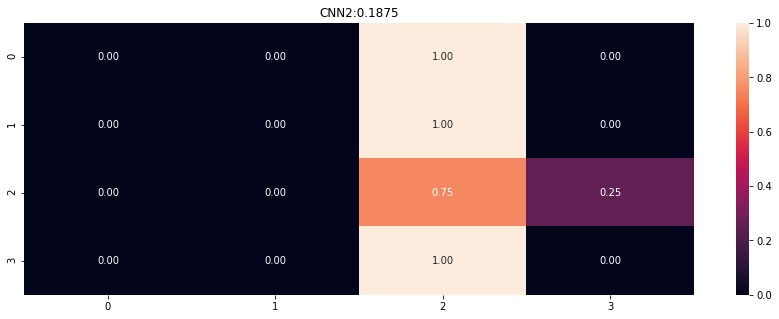

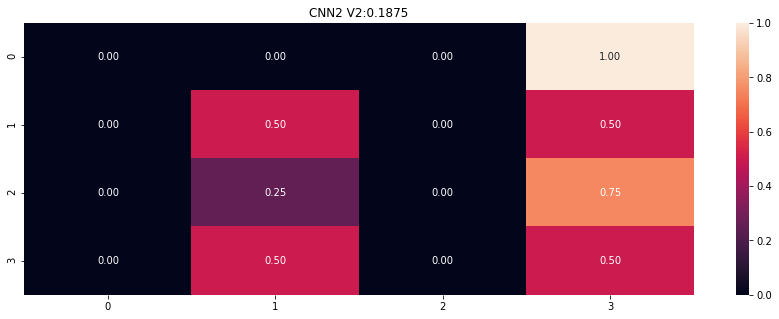

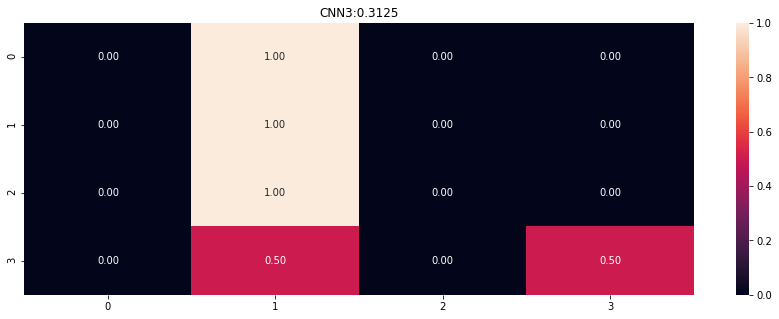

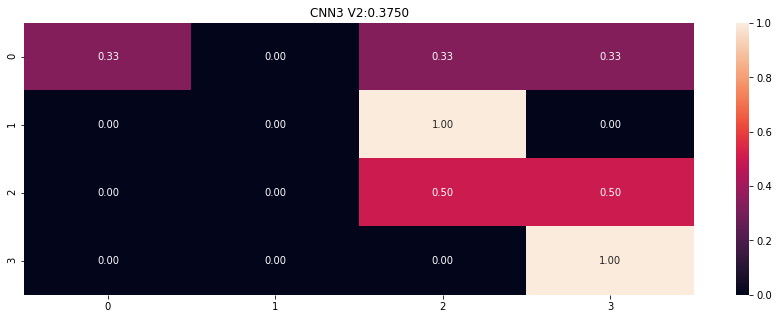

In [164]:
summarize_net(mlp, images[test], classifications[test], title_text='MLP:')
summarize_net(cnn1, images[test], classifications[test], title_text='CNN1:')
summarize_net(cnn2, images[test], classifications[test], title_text='CNN2:')
summarize_net(cnn2_2, images[test], classifications[test], title_text='CNN2 V2:')
summarize_net(cnn3, images[test], classifications[test], title_text='CNN3:')
summarize_net(cnn3_2, images[test], classifications[test], title_text='CNN3 V2:')

## MLP Comparison

### Load the test set

In [259]:
# Data for evaluation
images_mlp_comp, classifications_mlp_comp = load_images(['mlp_comp_images'])

classifications_mlp_comp = np.array(classifications , dtype=int)
classifications_mlp_comp_ohe = to_categorical(classifications_mlp_comp, NUM_CLASSES)

images_mlp_comp = np.array(images_mlp_comp, dtype=float)
max = images_mlp_comp.max()
images_mlp_comp /= max

Loading images from mlp_comp_images...
  0 images processed

Done
40 images available


### ROC Comparison

In [260]:
def compute_curve(y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_mlp.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr, tpr, roc_auc

In [261]:
def plot_curve(fpr_cnn, tpr_cnn, roc_auc_cnn, fpr_mlp, tpr_mlp, roc_auc_mlp):
    for i in range(NUM_CLASSES):
        plt.figure()
        plt.plot(fpr_cnn[i], tpr_cnn[i], label='CNN (area = %0.2f)' % roc_auc_cnn[i])
        plt.plot(fpr_mlp[i], tpr_mlp[i], label='MLP (area = %0.2f)' % roc_auc_mlp[i])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic: {}'.format(decode_classifier(i)))
        plt.legend(loc="lower right")
        plt.show()

In [262]:
y_score_mlp = mlp.predict(images_mlp_comp)
fpr_mlp, tpr_mlp, roc_auc_mlp = compute_curve(classifications_mlp_comp_ohe, y_score_mlp)

y_score_cnn = cnn3_2.predict(images_mlp_comp)
fpr_cnn, tpr_cnn, roc_auc_cnn = compute_curve(classifications_mlp_comp_ohe, y_score_cnn)

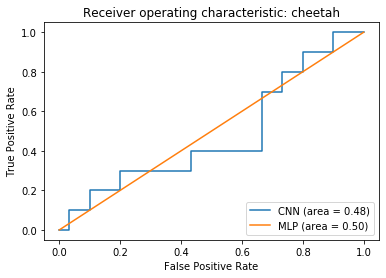

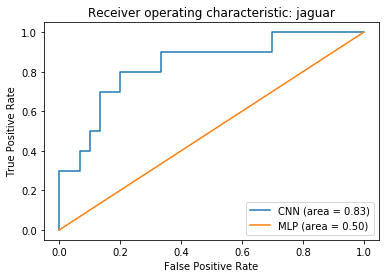

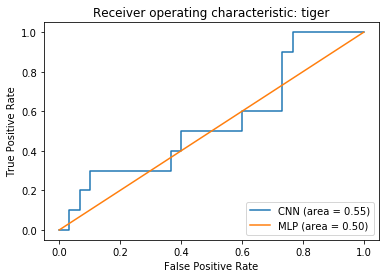

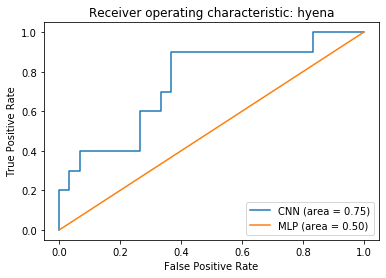

In [263]:
plot_curve2(fpr_cnn, tpr_cnn, roc_auc_cnn, fpr_mlp, tpr_mlp, roc_auc_mlp)

### ROC Analysis


TBD


### Statistical Test

In [268]:
models_titles = ['MLP', 'CNN']
comps = []

yhat = np.argmax(y_score_mlp, axis=1)
comp = np.equal(yhat, classifications_mlp_comp)
comps.append(comp)

yhat = np.argmax(y_score_cnn, axis=1)
comp = np.equal(yhat, classifications_mlp_comp)
comps.append(comp)

compare_comps(comps)

MLP vs CNN1
statistic=0.375, p-value=0.540
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------



### Statistical Conclusion


TBD

# Exceptional Work - Transfer Learning

## Transfer Learning
We're going to do is create a third dataset by agumenting the images similar to what we did in the data expansion exercise.  However, here, we're always flipping the images on the vertical access to create a mirror of the original.  Then we will make some minor rotations, etc.

We're using the VGG network pretrained on Imagenet.  Note that Imagenet classifies imagaes into the same four categories that we're using here (cheetah, tiger, lion, hyena).  So, simply running our images through the VGG network should yield highly accurate classifications

## Preperation

### Callback for saving training time
There are several very similar examples of this one the web. This one is adapted from https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

In [170]:
class TimingCallback(Callback):

    def __init__(self):
        self.logs=[]
    
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime=time()
    
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time()-self.starttime)
        print (time()-self.starttime)
    
    def get_elapsed_time(self):
        temp = np.array(self.logs)
        return temp.sum()

    def reset(self):
        self.logs=[]

### Load the new dataset
Note that the image format must be massaged a bit to use in the VGG model, so we create parallel arrays of the images, one for our model, and one for the VGG model.  The differences are basically in the normalization.  We do downsize out image to match the size expected by VGG (400x400 -> 224x224)

In [174]:
# The format that the images needs to be in to use with Imagenet pretraining is a little different
# than the format that we used.
images_xfer_imagenet = [] 
images_xfer_ours = []
classifications_xfer = []

processed_xfer = {}
for classifier in CLASSIFICATIONS.values():
    processed_xfer[classifier] = 0

print("\nLoading trasnsfer learning images...")
base_dir = os.path.join('.', 'transfer_images')
image_files = os.listdir(base_dir)
for image_file in image_files:
    
    if len(images_xfer_ours) % 400 == 0:
        print("  {} images procesed".format(len(images_xfer_ours)))
        
    classifier = get_classifier(image_file.split('_')[0]) # 0 - animal, 1 = unimportant parts
    if processed_xfer[classifier] < MAX_IMAGES_PER_CLASSIFICATION:
        try:
            img = io.imread(os.path.join(base_dir, image_file), as_gray=False)
            img = resize(img, (224, 224))
            images_xfer_ours.append(img)
            img = image.img_to_array(image.load_img(os.path.join(base_dir, image_file), target_size=(224, 224)))
            images_xfer_imagenet.append(img)
            classifications_xfer.append(classifier)
            processed_xfer[classifier] += 1
        except Exception as ex:
            print("Skipping " + file + " " + str(ex))

num_images_processed = sum(processed_xfer.values())
print("\nDone")
print("{} images available".format(num_images_processed))


Loading trasnsfer learning images...
  0 images procesed

Done
40 images available


### Normalize, OHE, Split

In [175]:
classifications_xfer = np.array(classifications_xfer , dtype=int)
print("Classifications array shape: {}".format(classifications_xfer.shape))

# Images for our model -- The images for the Imagenet model are already done
print("\nImages for our best model")
images_xfer_ours = np.array(images_xfer_ours, dtype=float)
max = images_xfer_ours.max()
print("\nBefore normalization - Min: {} Max {}".format(images_xfer_ours.min(), max))
images_xfer_ours /= max
print("After normalization - Min: {} Max {}".format(images_xfer_ours.min(), images_xfer_ours.max()))
print("Images array shape: {}".format(images_xfer_ours.shape))

# The images for the Imagenet model are already done
print("\nSame images for the Imagenet model")
images_xfer_imagenet = np.array(images_xfer_imagenet, dtype=float)
print("Images array shape: {}".format(images_xfer_imagenet.shape))

Classifications array shape: (40,)

Images for our best model

Before normalization - Min: 0.0 Max 1.0
After normalization - Min: 0.0 Max 1.0
Images array shape: (40, 224, 224, 3)

Same images for the Imagenet model
Images array shape: (40, 224, 224, 3)


In [176]:
from sklearn.model_selection import ShuffleSplit

XFER_DATA_SPLITS = 2 # 10

rs_xfer = ShuffleSplit(n_splits=XFER_DATA_SPLITS, test_size=.2, random_state=0)
rs_xfer.get_n_splits(images_xfer_ours)
iteration = 0
for train_index, test_index in rs_xfer.split(images_xfer_ours):
    print("Split #{}: Training samples = {} Testing samples = {}" .format(iteration, 
                                                                          len(train_index), 
                                                                          len(test_index)))
    iteration += 1

Split #0: Training samples = 32 Testing samples = 8
Split #1: Training samples = 32 Testing samples = 8


In [177]:
classifications_xfer_ohe = to_categorical(classifications_xfer, NUM_CLASSES)

## The original CNN with pre-training

### Some samples

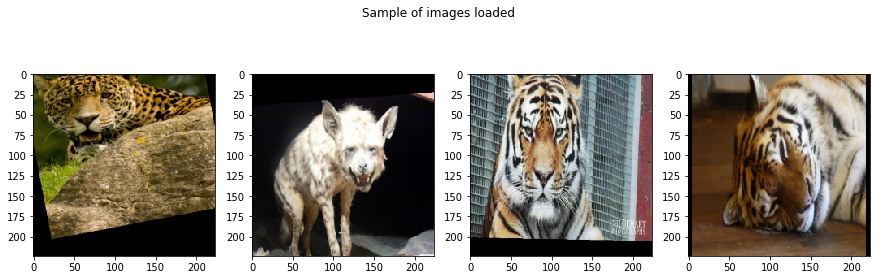

In [178]:
sample_indicies = np.random.default_rng().choice(images_xfer_ours.shape[0], images_xfer_ours.shape[0], replace=False)
sample_indicies = sample_indicies[:4]

show_images(sample_indicies.tolist(), images_xfer_ours, "Sample of images loaded")

In [179]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from skimage.transform import resize
    
def example_predict(model, image_index):
    sample = images_xfer_imagenet[image_index]
    sample = np.expand_dims(sample, axis=0)
    sample = preprocess_input(sample)
    prediction = model.predict(sample)
    print('Predicted:', decode_predictions(prediction, top=2)[0])
    print('Actual:', decode_classifier(classifications_xfer[image_index]))

In [180]:
vgg = VGG16(include_top=True, weights="imagenet")

In [181]:
for array_index, image_index in enumerate(sample_indicies):
    print("\nExample #{}".format(array_index+1))
    example_predict(vgg, image_index)


Example #1
Predicted: [('n02129604', 'tiger', 0.74868387), ('n02123159', 'tiger_cat', 0.24551924)]
Actual: tiger

Example #2
Predicted: [('n02129604', 'tiger', 0.75112283), ('n02123159', 'tiger_cat', 0.2299178)]
Actual: tiger

Example #3
Predicted: [('n02117135', 'hyena', 0.8375193), ('n02116738', 'African_hunting_dog', 0.047051527)]
Actual: hyena

Example #4
Predicted: [('n02128925', 'jaguar', 0.9630052), ('n02128385', 'leopard', 0.035419196)]
Actual: jaguar


### The Network

In [185]:
vgg = VGG16(include_top=False, weights="imagenet")

vgg_pred_elapsed_time = []
for index in range(10):
    vgg_pred_elapsed_time.append(time())
    images_xfer_imagenet = preprocess_input(images_xfer_imagenet)
    images_xfer_imagenet_preds = vgg.predict(images_xfer_imagenet)
    vgg_pred_elapsed_time[index] = time() - vgg_pred_elapsed_time[index]

In [187]:
# In the orignal CNN, we just did the convlusion and then fed it into one dense prediction layer.
# If we repeat that here, we're basically just takin the output from VGG and converting it into
# our classifiers
input_x = Input(shape=images_xfer_imagenet_preds[0].shape)
x = Flatten()(input_x)
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

cnn_xfer = Model(inputs=input_x, outputs=predictions)
cnn_xfer.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 7, 7, 512)]       0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 100356    
Total params: 100,356
Trainable params: 100,356
Non-trainable params: 0
_________________________________________________________________


In [188]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_xfer.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[custom_f1])

histories_cnn_xfer = []
times_cnn_xfer = []

timer = TimingCallback()

for train, test in rs_xfer.split(images_xfer_imagenet):
    timer.reset()
    history = cnn_xfer.fit(x=images_xfer_imagenet_preds[train], 
                           y=classifications_xfer_ohe[train],
                           validation_data = (images_xfer_imagenet_preds[test], classifications_xfer_ohe[test]),
                           epochs=EPOCHS, 
                           batch_size=BATCH_SIZE,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE), timer])
    histories_cnn_xfer.append(history)
    times_cnn_xfer.append(timer.get_elapsed_time())

Train on 32 samples, validate on 8 samples
Epoch 1/2
0.5433080196380615
32/32 [==============================] - 1s 17ms/sample - loss: 0.3622 - custom_f1: 0.2812 - val_loss: 0.5000 - val_custom_f1: 0.0000e+00
Epoch 2/2
0.017972469329833984
32/32 [==============================] - 0s 562us/sample - loss: 0.2812 - custom_f1: 0.4375 - val_loss: 0.5000 - val_custom_f1: 0.0000e+00
Train on 32 samples, validate on 8 samples
Epoch 1/2
0.020987749099731445
32/32 [==============================] - 0s 656us/sample - loss: 0.2969 - custom_f1: 0.4062 - val_loss: 0.3125 - val_custom_f1: 0.3750
Epoch 2/2
0.0139923095703125
32/32 [==============================] - 0s 469us/sample - loss: 0.2969 - custom_f1: 0.4062 - val_loss: 0.3125 - val_custom_f1: 0.3750


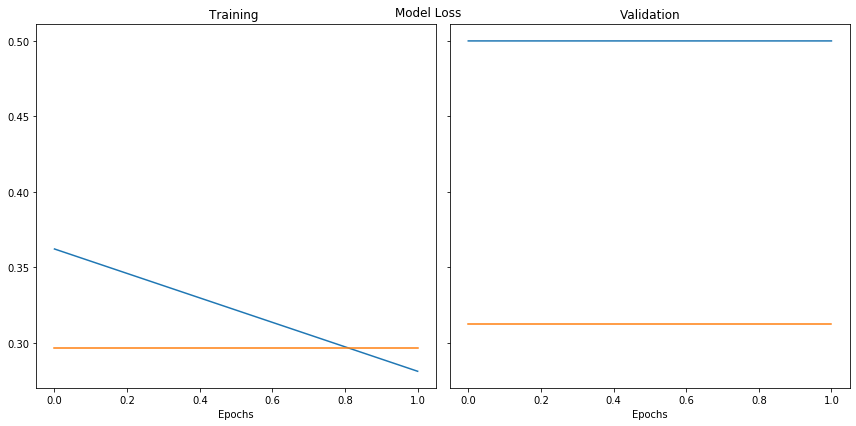

In [189]:
plot_loss(histories_cnn_xfer)

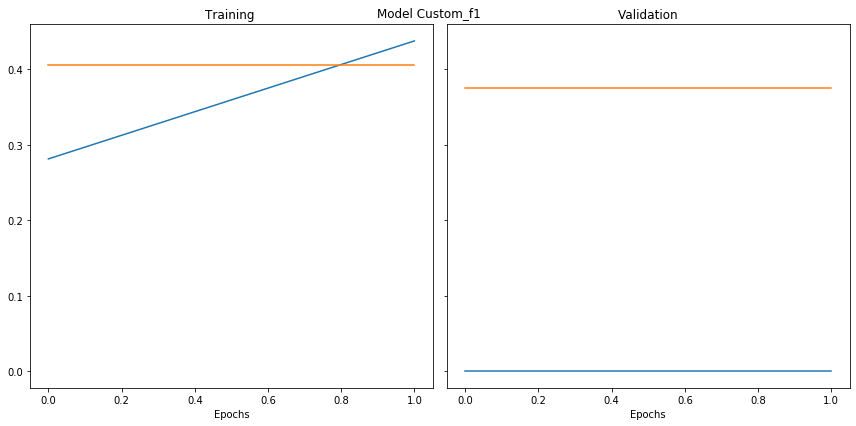

In [190]:
plot_custom_f1(histories_cnn_xfer)

## Our Best Model (3.2)
Here, we retrain on the new dataset just as before, but now, we'll keep track of the time it takes

### The Network

In [196]:
# We changed the image size to match VGG's input, so we adjust the input layer.  We found a utility (kerassurgeon)
# but couldn't get it working with Anaconda, we we're simply recreating the model
input_holder = Input(shape=(images_xfer_ours.shape[1], images_xfer_ours.shape[2], images_xfer_ours.shape[3]))

x = Conv2D(filters=64,
               input_shape = (images_xfer_ours.shape[1], images_xfer_ours.shape[2], images_xfer_ours.shape[3]),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

In [197]:
# This is the same as before
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=256,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=128,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(4)(x)
x = Activation('softmax')(x)

cnn3_2 = Model(inputs=input_holder, outputs=x)
cnn3_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[custom_f1])
cnn3_2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 224, 224, 64) 1792        input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 112, 112, 128 73856       max_pooling2d_24[0][0]           
____________________________________________________________________________________________

In [198]:
histories_cnn_32 = []
times_cnn_32 = []

timer = TimingCallback()

for train, test in rs_xfer.split(images_xfer_ours):
    timer.reset()
    history = cnn3_2.fit(x=images_xfer_ours[train], 
                         y=classifications_xfer_ohe[train],
                         validation_data = (images_xfer_ours[test], classifications_xfer_ohe[test]),
                         epochs=EPOCHS, 
                         batch_size=BATCH_SIZE,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE), timer])
    histories_cnn_32.append(history)
    times_cnn_32.append(timer.get_elapsed_time())

Train on 32 samples, validate on 8 samples
Epoch 1/2
9.80117654800415
32/32 [==============================] - 10s 306ms/sample - loss: 16.2678 - custom_f1: 0.1656 - val_loss: 415.0919 - val_custom_f1: 0.1250
Epoch 2/2
8.33821964263916
32/32 [==============================] - 8s 261ms/sample - loss: 183.7835 - custom_f1: 0.2812 - val_loss: 114.0219 - val_custom_f1: 0.1250
Train on 32 samples, validate on 8 samples
Epoch 1/2
8.869915008544922
32/32 [==============================] - 9s 277ms/sample - loss: 156.4846 - custom_f1: 0.3438 - val_loss: 30.1681 - val_custom_f1: 0.3750
Epoch 2/2
8.960861444473267
32/32 [==============================] - 9s 280ms/sample - loss: 56.6055 - custom_f1: 0.2500 - val_loss: 21.1495 - val_custom_f1: 0.2500


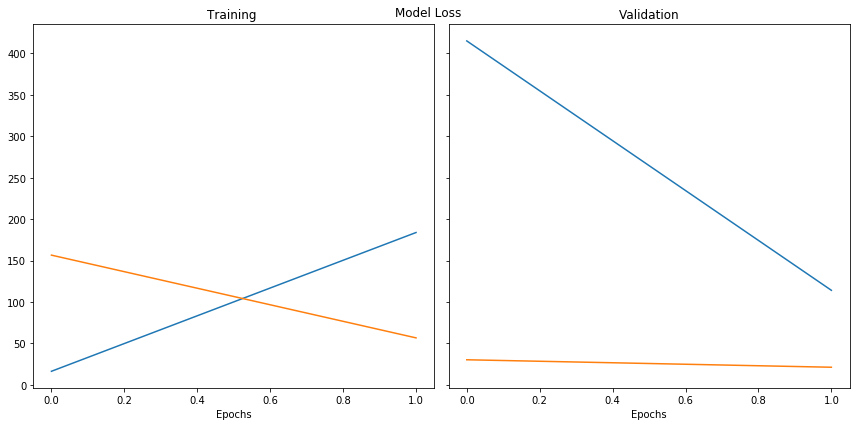

In [199]:
plot_loss(histories_cnn_32)

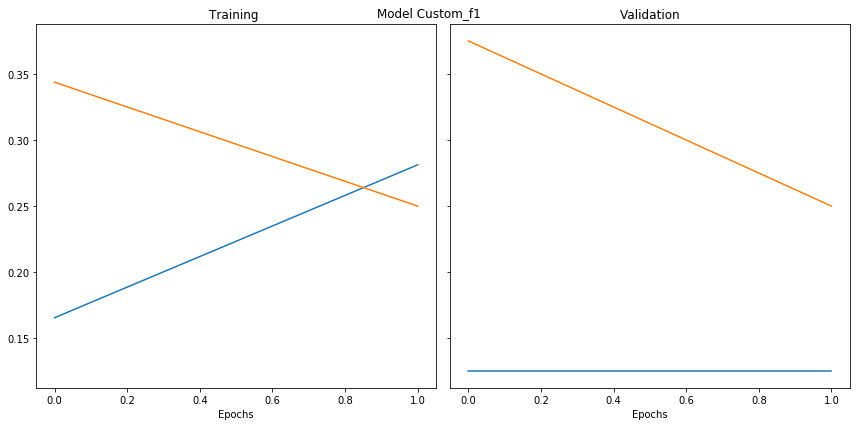

In [200]:
plot_custom_f1(histories_cnn_32)

### Performance Comparison

In [201]:
models = [cnn_xfer, cnn3_2]
models_titles = ['cnn_xfer', 'cnn3_2']
true_counts = []
comps = []

yhat = np.argmax(cnn_xfer.predict(images_xfer_imagenet_preds[test]), axis=1)
comp = np.equal(yhat, classifications_xfer[test])
comps.append(comp)

yhat = np.argmax(cnn3_2.predict(images_xfer_ours[test]), axis=1)
comp = np.equal(yhat, classifications_xfer[test])
comps.append(comp)
compare_comps(comps)

cnn_xfer vs cnn3_2
statistic=0.000, p-value=1.000
No meaningful difference in performance (fail to reject H0)
-----------------------------------------------------------



### Time Comparison

Time Statistics
---------------
Pretraining mean: 20.49945111274719 standard deviation: 1.9542406351874406
Basic CNN Pretrained mean*: 24.706062656941043 standard deviation: 0.2631502151489258
 * excludes above pretraining time

Our Best Model (3.2) mean: 17.98508632183075 standard deviation: 0.15430986881256104


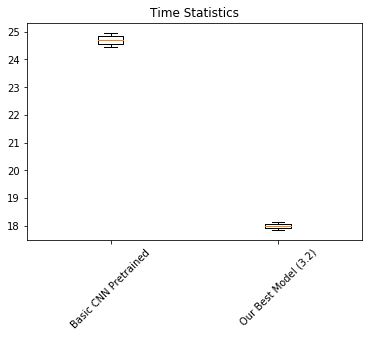

In [203]:
label1 = "Basic CNN Pretrained"
label2 = "Our Best Model (3.2)"
title = 'Time Statistics'

print(title)
print('---------------')
pretrain_mean = np.mean(vgg_pred_elapsed_time)
pretrain_std = np.std(vgg_pred_elapsed_time)
pretrain_adjust = pretrain_mean + 2 * pretrain_std
print("Pretraining mean: {} standard deviation: {}".format(pretrain_mean, pretrain_std))
print('{} mean*: {} standard deviation: {}'.format(label1, np.mean(times_cnn_xfer), np.std(times_cnn_xfer)))
print(' * excludes above pretraining time')
print()
print('{} mean: {} standard deviation: {}'.format(label2, np.mean(times_cnn_32), np.std(times_cnn_32)))

distribution_labels = [label1, label2]
distributions = [times_cnn_xfer, times_cnn_32]
plt.boxplot(distributions, labels=distribution_labels)
plt.xticks(rotation=45)
plt.title(title)
plt.show()

### Comparison Conclusion


TBD

